# Exercise 2: Neural Networks

In the previous exercise you implemented a classifier with one linear layer. In this exercise, you will implement a three layer multi-class neural network.

## Submission guidelines:

Your submission should only include this jupyter notebook named ex2_ID.ipynb (not in zip).

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors.
7. **Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. You should include your desired outputs in the output cells to make your code easier to understand.**
8. Write your own code. Cheating will not be tolerated. 
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

**TIP:** You may find the following link helpful: 
http://cs231n.github.io/neural-networks-case-study

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing


## Data download and processing Helper Code

In [2]:
def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        print("Downloading, This might take several minutes.")
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")
        print("If not, delete the dataset folder and try again.")

def load_CIFAR_batch(filename):
    ''' load single batch of cifar '''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load(ROOT):
    ''' load all of cifar '''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

The next cell will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.


In [3]:
# this cell will download the data if it does not exists
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
maybe_download_and_extract(URL, PATH) 

Data has apparently already been downloaded and unpacked.
If not, delete the dataset folder and try again.


## Data Preprocessing

**Notice that we are leaving behind the bias trick in this exercise.**

In [4]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH) # load the entire data
num_classes = 4

X_train = X_train[np.isin(y_train, range(num_classes))]
y_train = y_train[np.isin(y_train, range(num_classes))]
X_test = X_test[np.isin(y_test, range(num_classes))]
y_test = y_test[np.isin(y_test, range(num_classes))]

# define a splitting for the data
num_training = num_classes*5000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

print(f"Shape of training set: {X_train.shape}")
print(f"Shape of validation set: {X_val.shape}")
print(f"Shape of test set: {X_test.shape}")

classes = ['plane', 'car', 'bird', 'cat']

Shape of training set: (20000, 3072)
Shape of validation set: (1000, 3072)
Shape of test set: (1000, 3072)


      car     plane     plane     plane


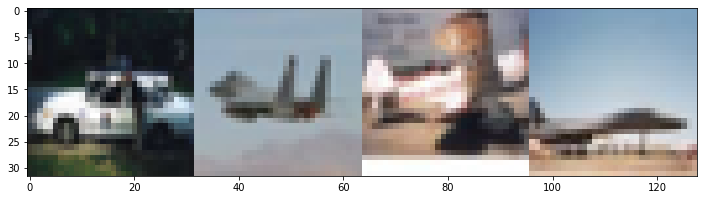

In [5]:
def get_batch(X, y, n=1000):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels

def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print(' '.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid

def vec_2_img(x):
    x = np.reshape(x, (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, convert_to_image=True));

# Loss

## Cross-entropy


Complete the function `softmax_loss` using vectorized code. This function takes as input `scores`, labels `y` and outputs the calculated loss as a single number and the gradients with respect to X. **(10 Points)**

In [6]:
def softmax_loss(scores, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - scores: scores of shape (N, C) where scores[i, c] is the score for class c on input X[i].
    - y: Vector of labels

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    ###########################################################################
    # TODO: Implement this function                                           #
    ###########################################################################
    
    # number of samples
    num_samples = scores.shape[0]

    # Get probabilities
    exp_scores = np.exp(scores)
    probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Get loss
    # for every sample, get the probability of the correct class and take the negative log
    loss = -np.sum(np.log(probabilities[np.arange(num_samples), y])) / num_samples
    
    # Get gradient
    dx = probabilities.copy()
    # for every sample, subtract 1 from the probability of the correct class
    dx[np.arange(num_samples), y] -= 1
    dx /= num_samples


    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return loss, dx

In [7]:
# some tests
np.random.seed(42)

num_instances = 5
num_classes = 3

y = np.random.randint(num_classes, size=num_instances)
scores = np.random.randn(num_instances * num_classes).reshape(num_instances, num_classes)
loss, dx = softmax_loss(scores, y)


correct_grad = np.array([[ 0.0062,  0.1751, -0.1813],
         [-0.1463,  0.0561,  0.0901],
         [ 0.0404,  0.0771, -0.1174],
         [ 0.0223,  0.0855, -0.1078],
         [-0.1935,  0.1358,  0.0578]])
correct_loss = 1.7544
assert np.isclose(dx.round(4), correct_grad, rtol=1e-3).all()
assert np.isclose(loss.round(4), correct_loss, rtol=1e-3).all()

## L2 Regularization

Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights. 
$$
Loss = Loss + \lambda  \cdot \frac{1}{2} \cdot \sum_{i=0}^k w_k^2
$$

Implement the L2 regularization part of the loss in the next cell: **(10 Points)**

In [8]:
def l2_regulariztion_loss(W, reg=0):
    """
    L2 regulariztion loss function, vectorized version.
    - W: a layer's weights.
    - reg: (float) regularization strength
    """
    loss = 0.0
    dW = np.zeros_like(W)
    #############################################################################
    # TODO: Compute the L2 reulariztion loss and its gradient using no 
    # explicit loops.                                                           #
    # Store the loss in loss and the gradient in dW.                            #
    #############################################################################

    # calculate loss
    loss = loss + reg *0.5* np.sum(W * W)
    
    # calculate gradient
    dW = dW + reg * W
    
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

# Neural Network

The implementation of linear regression was (hopefully) simple yet not very modular since the layer, loss and gradient were calculated as a single monolithic function. This would become impractical as we move towards bigger models. As a warmup towards `PyTorch`, we want to build networks using a more modular design so that we can implement different layer types in isolation and easily integrate them together into models with different architectures.

This logic of isolation & integration is at the heart of all popular deep learning frameworks, and is based on two methods each layer holds - a forward and backward pass. The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass. The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights. By implementing several types of layers this way, we will be able to easily combine them to build classifiers with different architectures with relative ease.

We will implement a neural network to obtain better results on CIFAR-10. 
Our neural network will be implemented in the following cells. We will train this network using softmax loss and L2 regularization and a ReLU non-linearity.



### Fully Connected Layer: Forward Pass. 

Implement the function `fc_forward`. **(5 Points)**

In [9]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for an fully connected layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - W: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################

    # Reshape input into rows
    # X.shape = (N,32,32,3) 3-->RGB
    x_vector = np.reshape(X, (X.shape[0], -1))

    # Calculate output: z= WX + b
    out = x_vector.dot(W) + b

    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (X.copy(), W.copy(), b.copy())
    return out, cache

In [10]:
np.random.seed(42)

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

assert np.isclose(out, correct_out, rtol=1e-8).all()

### Fully Connected Layer: Backward Pass 

Implement the function `fc_backward` **(5 Points)**

In [11]:
def fc_backward(dout, cache):
    """
    Computes the backward pass for an fully connected layer.
    Try the link in the exercise intructions for more details.

    Inputs:
    - dout: Upstream derivatives
    - cache: Tuple of:
      - X: Input data
      - W: Weights
      - b: Biases

    Returns a tuple of:
    - dx: Gradient with respect to X
    - dw: Gradient with respect to W
    - db: Gradient with respect to b
    """
    x, w, b = cache
    dx, dw, db = 0, 0, 0
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################

    # Reshape input into rows
    x_vector = np.reshape(x, (x.shape[0], -1))
    
    # Calculate gradients
    # dx= W * dout
    # N: number of samples
    # M: number of classes
    # D: number of features
    dx = dout.dot(w.T).reshape(x.shape) # (N, M) * (M, D) = (N, D)
    # dw= X * dout
    dw = x_vector.T.dot(dout) # (D, N) * (N, M) = (D, M)
    # db= dout
    db = np.sum(dout, axis=0) # (N, M) --> (M,)

    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [12]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [13]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

### ReLU: Forward Pass 

Implement the function `relu_forward`. **(5 Points)**

In [14]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################

    out = np.maximum(0, x)
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x.copy()
    return out, cache

In [15]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

assert np.isclose(out, correct_out, rtol=1e-8).all() # simple test

### ReLU: Backward Pass

Implement the function `relu_backward`. **(5 Points)**

In [16]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    #############################################################################
    # TODO: Implement the ReLU backward pass.                                   #
    #############################################################################

    # Derivative of ReLU is 1 if x > 0, 0 otherwise. Perform element-wise multiplication.
    dx = dout * (x > 0) # elements are dout if x > 0, 0 otherwise
    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx

In [17]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

assert np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test

### Combined Layer
Next combine the fully connected and relu forward\backward functions togther using the functions in the following cell. 
Remember to use functions you already implemented.
**(5 Points)**

In [18]:
def fc_relu_forward(X, W, b):
    """
    Forward pass for a fully connected layer followed by a ReLU.

    Inputs:
    - X: Input to the fc layer
    - W, b: Weights for the fc layer

    Returns:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################

    # Forward pass for fully connected layer
    fc_out, fc_cache = fc_forward(X, W, b)

    # Forward pass for ReLU
    out, relu_cache = relu_forward(fc_out)
    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (fc_cache, relu_cache)
    return out, cache


def fc_relu_backward(dout, cache):
    """
    Backward pass for a fully connected layer followed by a ReLU
    Inputs:
    - dout: upstream derivatives
    - cache: parameters calculated during the forward pass

    Returns:
    - dX: derivative w.r.t X
    - dW: derivative w.r.t W
    - db: derivative w.r.t b
    """
    fc_cache, relu_cache = cache
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################

    # Backward pass for ReLU
    drelu = relu_backward(dout, relu_cache) # gradient of loss function with respect to the outputs of the ReLU layer

    # Backward pass for fully connected layer
    dx, dw, db = fc_backward(drelu, fc_cache) # gradient of loss function with respect to the inputs, weights, biases of the fully connected layer
    
    
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dw, db

You can check your results in the next cell:

In [19]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dout)

out, cache = fc_relu_forward(x,w,b)
dx, dw, db = fc_relu_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

# Building the Network



Complete the class `ThreeLayerNet`. **(35 Points)**

In [20]:
class ThreeLayerNet(object):
    """
    A three-layer fully-connected neural network. This network has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    In our case, we use the same hidden dimension across all hidden layers.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. In other words, the network has the following architecture:

    input - fc layer - ReLU - fc layer - ReLu - fc layer - softmax

    The outputs of the third fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-2):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, H)
        b2: Second layer biases; has shape (H,)
        W3: Second layer weights; has shape (H, C)
        b3: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in each of the hidden layers.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

    def step(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a three layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization coefficient.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################

        # Forward pass for first fully connected layer
        fc1_out, fc1_cache = fc_forward(X, W1, b1)

        # Forward pass for ReLU
        relu1_out, relu1_cache = relu_forward(fc1_out)

        # Forward pass for second fully connected layer
        fc2_out, fc2_cache = fc_forward(relu1_out, W2, b2)

        # Forward pass for ReLU
        relu2_out, relu2_cache = relu_forward(fc2_out)

        # Forward pass for third fully connected layer
        scores, fc3_cache = fc_forward(relu2_out, W3, b3)
        
        
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        ###############################################################################
        # After you finished the forward pass, compute the loss. This should include  #
        # both the data loss and L2 regularization for W1, W2, W3. Store the result   #
        # in the variable loss, which should be a scalar. Use the softmax_loss        #
        # and l2_regulariztion_loss functions you implemented.                        #         
        ###############################################################################

        
        # Calculate loss
        softmax_loss_result, softmax_d = softmax_loss(scores, y)

        # Calculate regularization loss
        l2_loss1, l2_d1 = l2_regulariztion_loss(W1, reg) # l2_loss1 is the loss for W1
        l2_loss2, l2_d2 = l2_regulariztion_loss(W2, reg) # l2_loss2 is the loss for W2
        l2_loss3, l2_d3 = l2_regulariztion_loss(W3, reg) # l2_loss3 is the loss for W3
        l2_loss = l2_loss1 + l2_loss2 + l2_loss3

        # Calculate total loss
        loss = softmax_loss_result + l2_loss
        
        
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] = dW1 + dW1_reg, it stores the gradient on W1, including      #
        # regularization. It should be a matrix of the same size.                   #
        #############################################################################

        
        # Backward pass for third fully connected layer
        dx3, dw3, db3 = fc_backward(softmax_d, fc3_cache)
        # Add regularization gradient contribution
        dw3 += l2_d3

        # Backward pass for ReLU
        drelu2 = relu_backward(dx3, relu2_cache)

        # Backward pass for second fully connected layer
        dx2, dw2, db2 = fc_backward(drelu2, fc2_cache)
        # Add regularization gradient contribution
        dw2 += l2_d2

        # Backward pass for ReLU
        drelu1 = relu_backward(dx2, relu1_cache)

        # Backward pass for first fully connected layer
        dx1, dw1, db1 = fc_backward(drelu1, fc1_cache)
        # Add regularization gradient contribution
        dw1 += l2_d1

        # Store gradients in dictionary
        grads['W1'] = dw1
        grads['b1'] = db1
        grads['W2'] = dw2
        grads['b2'] = db2
        grads['W3'] = dw3
        grads['b3'] = db3

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training label.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None
            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################

            # Get random batch of training data
            X_batch, y_batch = get_batch(X, y, batch_size)

            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.step(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################

            
            # Update parameters
            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2']
            self.params['W3'] -= learning_rate * grads['W3']
            self.params['b3'] -= learning_rate * grads['b3']

            
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and (it+1) % 100 == 0:
                print ('iteration %d / %d: loss %f' % (it+1, num_iters, loss))

            # Every epoch, check train and val accuracy.
            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this three-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: data points to classify.

        Returns:
        - y_pred: predicted labels
        """
        y_pred = None
        # Unpack variables from the params dictionary that was passed to the train() function
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3'] 

        ###########################################################################
        # TODO: Implement this function                                           #
        ###########################################################################

        # Forward pass for first fully connected layer
        fc1_out, fc1_cache = fc_forward(X, W1, b1)

        # Forward pass for ReLU
        relu1_out, relu1_cache = relu_forward(fc1_out)

        # Forward pass for second fully connected layer
        fc2_out, fc2_cache = fc_forward(relu1_out, W2, b2)

        # Forward pass for ReLU
        relu2_out, relu2_cache = relu_forward(fc2_out)

        # Forward pass for third fully connected layer
        # scores represent the probabilities of each class
        scores, fc3_cache = fc_forward(relu2_out, W3, b3)

        # Get predictions
        # y_pred is the class with the highest probability
        y_pred = np.argmax(scores, axis=1)

                
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################
        return y_pred

In [21]:
input_size = 32 * 32 * 3
hidden_size = 128
num_classes = 4
model = ThreeLayerNet(input_size, hidden_size, num_classes)

In [22]:
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

iteration 100 / 1500: loss 1.084206
iteration 200 / 1500: loss 1.004476
iteration 300 / 1500: loss 0.900380
iteration 400 / 1500: loss 0.825731
iteration 500 / 1500: loss 0.857723
iteration 600 / 1500: loss 0.719607
iteration 700 / 1500: loss 0.754655
iteration 800 / 1500: loss 0.759193
iteration 900 / 1500: loss 0.672972
iteration 1000 / 1500: loss 0.658957
iteration 1100 / 1500: loss 0.763658
iteration 1200 / 1500: loss 0.724688
iteration 1300 / 1500: loss 0.629747
iteration 1400 / 1500: loss 0.711940
iteration 1500 / 1500: loss 0.669238


In [23]:
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.703


In [24]:
train_acc = (model.predict(X_train) == y_train).mean()
print ('Training accuracy: ', train_acc)

Training accuracy:  0.7445


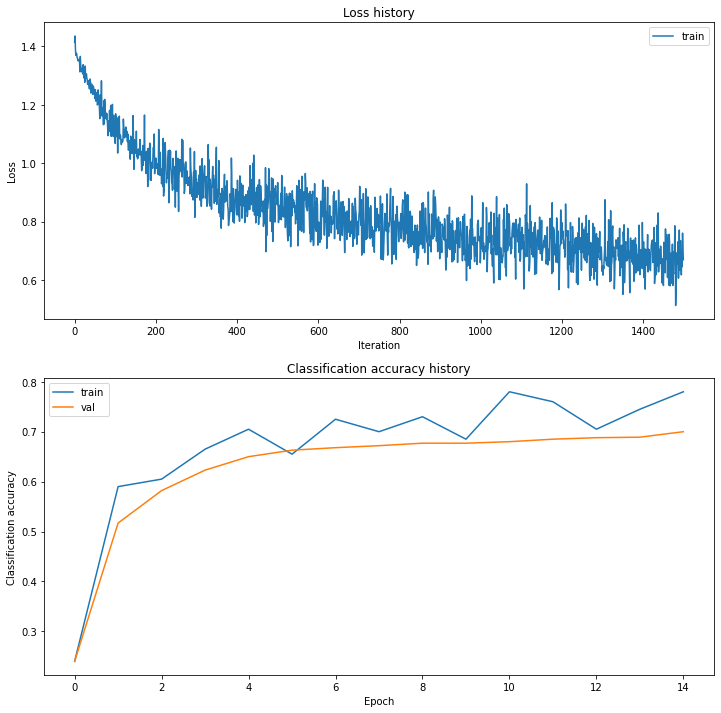

In [25]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'], label='train')
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')

# Add legend
plt.legend()

plt.show()

## Hyperparameter Optimization
Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. You should evaluate the best model on the testing dataset and print out the training, validation and testing accuracies for each of the models and provide a clear visualization. Highlight the best model w.r.t the testing accuracy. **(10 Points)**

iteration 100 / 1500: loss 1.376390
iteration 200 / 1500: loss 1.372615
iteration 300 / 1500: loss 1.361744
iteration 400 / 1500: loss 1.356286
iteration 500 / 1500: loss 1.360555
iteration 600 / 1500: loss 1.346128
iteration 700 / 1500: loss 1.339200
iteration 800 / 1500: loss 1.316696
iteration 900 / 1500: loss 1.298758
iteration 1000 / 1500: loss 1.300646
iteration 1100 / 1500: loss 1.276588
iteration 1200 / 1500: loss 1.286938
iteration 1300 / 1500: loss 1.289982
iteration 1400 / 1500: loss 1.309080
iteration 1500 / 1500: loss 1.291031
Validation accuracy:  0.435
Training accuracy:  0.4457


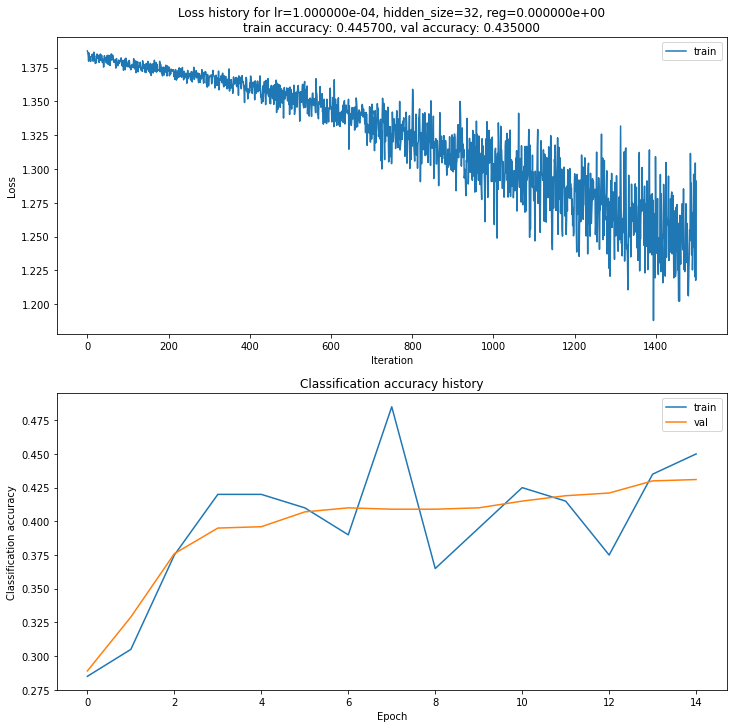

iteration 100 / 1500: loss 1.382169
iteration 200 / 1500: loss 1.375423
iteration 300 / 1500: loss 1.369791
iteration 400 / 1500: loss 1.374633
iteration 500 / 1500: loss 1.355282
iteration 600 / 1500: loss 1.353082
iteration 700 / 1500: loss 1.335570
iteration 800 / 1500: loss 1.351932
iteration 900 / 1500: loss 1.330583
iteration 1000 / 1500: loss 1.313140
iteration 1100 / 1500: loss 1.305973
iteration 1200 / 1500: loss 1.335722
iteration 1300 / 1500: loss 1.276826
iteration 1400 / 1500: loss 1.271935
iteration 1500 / 1500: loss 1.275730
Validation accuracy:  0.443
Training accuracy:  0.44575


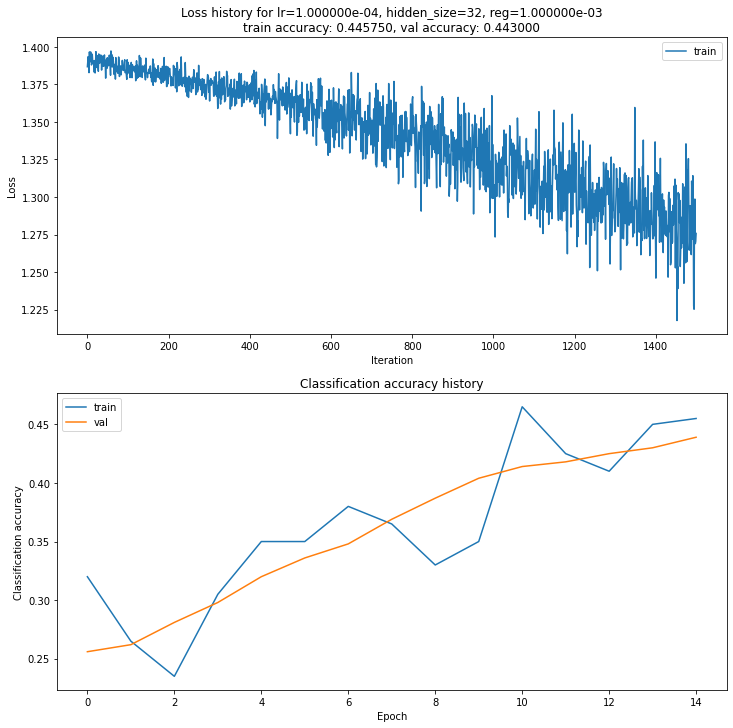

iteration 100 / 1500: loss 1.881304
iteration 200 / 1500: loss 1.878638
iteration 300 / 1500: loss 1.865191
iteration 400 / 1500: loss 1.866520
iteration 500 / 1500: loss 1.858125
iteration 600 / 1500: loss 1.847623
iteration 700 / 1500: loss 1.847588
iteration 800 / 1500: loss 1.836207
iteration 900 / 1500: loss 1.828889
iteration 1000 / 1500: loss 1.815405
iteration 1100 / 1500: loss 1.810271
iteration 1200 / 1500: loss 1.799280
iteration 1300 / 1500: loss 1.796272
iteration 1400 / 1500: loss 1.785357
iteration 1500 / 1500: loss 1.819203
Validation accuracy:  0.45
Training accuracy:  0.4473


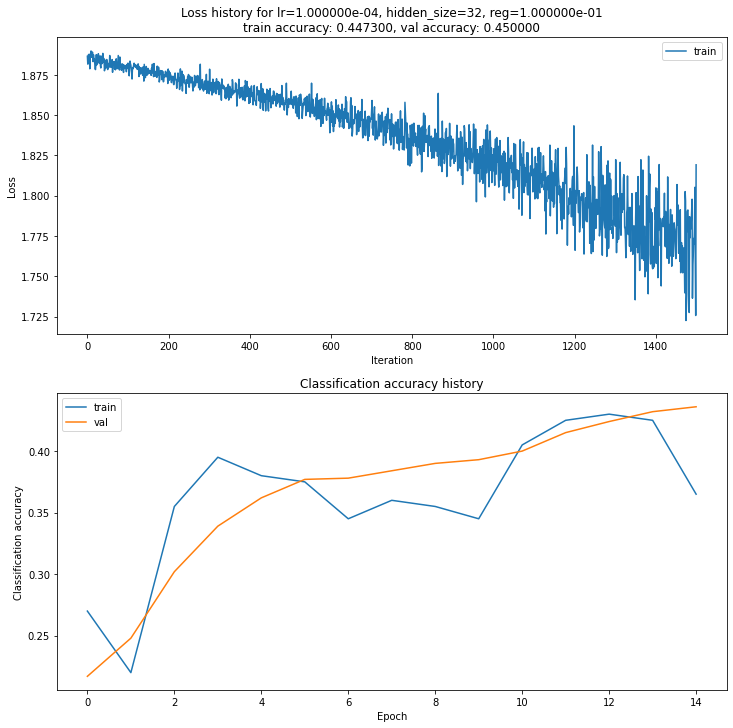

iteration 100 / 1500: loss 2.616932
iteration 200 / 1500: loss 2.602549
iteration 300 / 1500: loss 2.588193
iteration 400 / 1500: loss 2.583527
iteration 500 / 1500: loss 2.563888
iteration 600 / 1500: loss 2.560604
iteration 700 / 1500: loss 2.538723
iteration 800 / 1500: loss 2.536708
iteration 900 / 1500: loss 2.521116
iteration 1000 / 1500: loss 2.520095
iteration 1100 / 1500: loss 2.479173
iteration 1200 / 1500: loss 2.455081
iteration 1300 / 1500: loss 2.466820
iteration 1400 / 1500: loss 2.424899
iteration 1500 / 1500: loss 2.424231
Validation accuracy:  0.427
Training accuracy:  0.4418


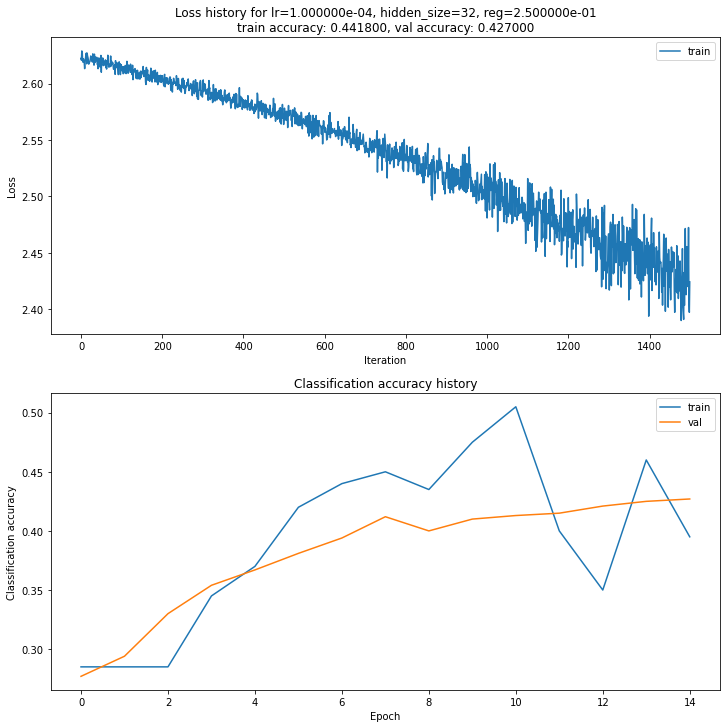

iteration 100 / 1500: loss 1.374275
iteration 200 / 1500: loss 1.338406
iteration 300 / 1500: loss 1.326640
iteration 400 / 1500: loss 1.300888
iteration 500 / 1500: loss 1.276639
iteration 600 / 1500: loss 1.263790
iteration 700 / 1500: loss 1.271640
iteration 800 / 1500: loss 1.252862
iteration 900 / 1500: loss 1.214412
iteration 1000 / 1500: loss 1.249537
iteration 1100 / 1500: loss 1.232359
iteration 1200 / 1500: loss 1.167234
iteration 1300 / 1500: loss 1.151977
iteration 1400 / 1500: loss 1.140389
iteration 1500 / 1500: loss 1.106317
Validation accuracy:  0.52
Training accuracy:  0.5217


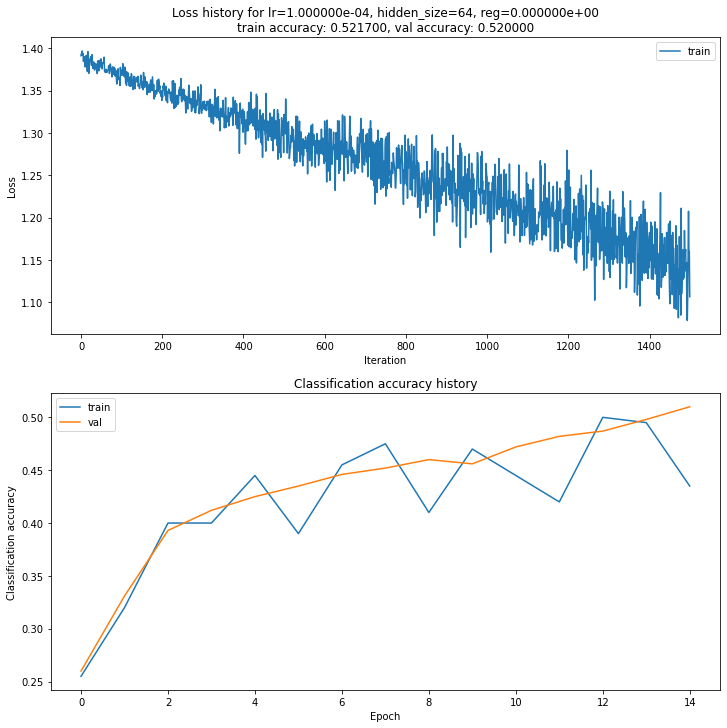

iteration 100 / 1500: loss 1.382302
iteration 200 / 1500: loss 1.379761
iteration 300 / 1500: loss 1.379339
iteration 400 / 1500: loss 1.331557
iteration 500 / 1500: loss 1.327532
iteration 600 / 1500: loss 1.364678
iteration 700 / 1500: loss 1.305012
iteration 800 / 1500: loss 1.265646
iteration 900 / 1500: loss 1.281409
iteration 1000 / 1500: loss 1.258022
iteration 1100 / 1500: loss 1.244787
iteration 1200 / 1500: loss 1.286220
iteration 1300 / 1500: loss 1.223021
iteration 1400 / 1500: loss 1.244237
iteration 1500 / 1500: loss 1.170856
Validation accuracy:  0.487
Training accuracy:  0.4912


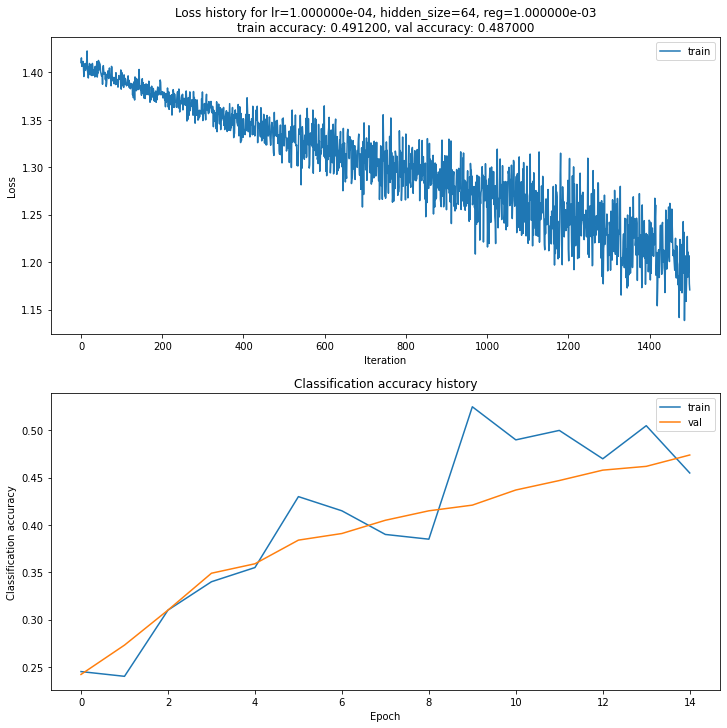

iteration 100 / 1500: loss 2.363884
iteration 200 / 1500: loss 2.346409
iteration 300 / 1500: loss 2.342241
iteration 400 / 1500: loss 2.305085
iteration 500 / 1500: loss 2.305034
iteration 600 / 1500: loss 2.301488
iteration 700 / 1500: loss 2.251063
iteration 800 / 1500: loss 2.312273
iteration 900 / 1500: loss 2.228074
iteration 1000 / 1500: loss 2.178955
iteration 1100 / 1500: loss 2.197143
iteration 1200 / 1500: loss 2.260011
iteration 1300 / 1500: loss 2.222302
iteration 1400 / 1500: loss 2.113614
iteration 1500 / 1500: loss 2.193149
Validation accuracy:  0.497
Training accuracy:  0.5218


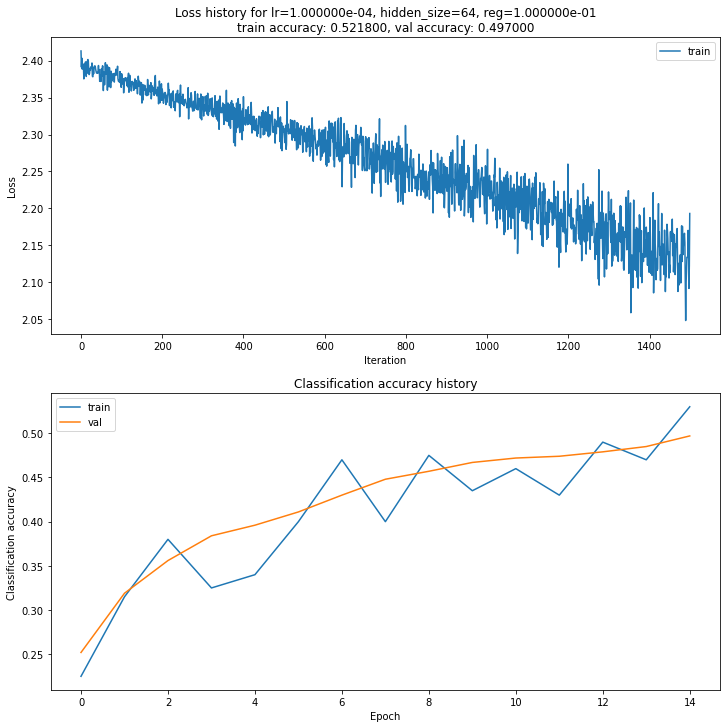

iteration 100 / 1500: loss 3.871126
iteration 200 / 1500: loss 3.861155
iteration 300 / 1500: loss 3.797949
iteration 400 / 1500: loss 3.807913
iteration 500 / 1500: loss 3.782552
iteration 600 / 1500: loss 3.722223
iteration 700 / 1500: loss 3.728580
iteration 800 / 1500: loss 3.719930
iteration 900 / 1500: loss 3.640230
iteration 1000 / 1500: loss 3.597227
iteration 1100 / 1500: loss 3.557957
iteration 1200 / 1500: loss 3.588474
iteration 1300 / 1500: loss 3.528763
iteration 1400 / 1500: loss 3.547981
iteration 1500 / 1500: loss 3.534047
Validation accuracy:  0.517
Training accuracy:  0.5111


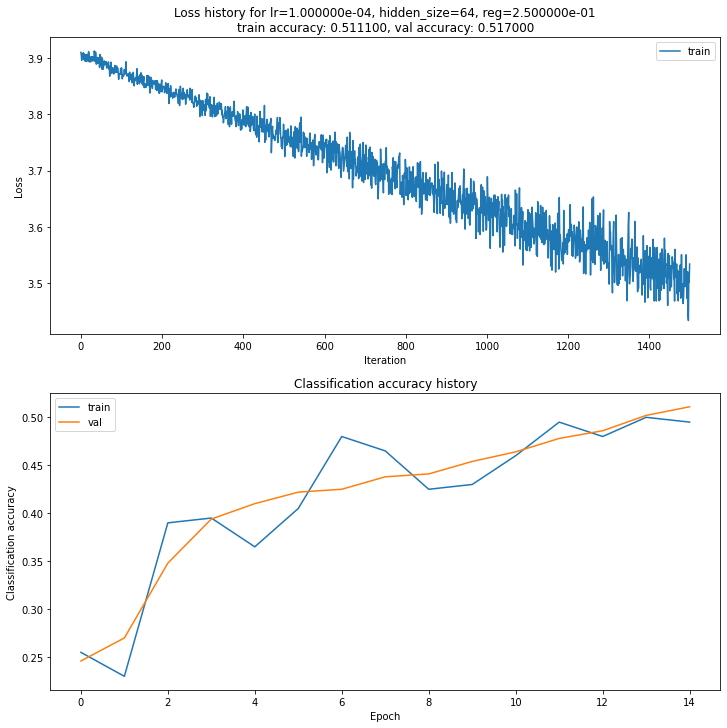

iteration 100 / 1500: loss 1.348982
iteration 200 / 1500: loss 1.290453
iteration 300 / 1500: loss 1.288942
iteration 400 / 1500: loss 1.254728
iteration 500 / 1500: loss 1.145828
iteration 600 / 1500: loss 1.212254
iteration 700 / 1500: loss 1.142747
iteration 800 / 1500: loss 1.175473
iteration 900 / 1500: loss 1.130504
iteration 1000 / 1500: loss 1.058078
iteration 1100 / 1500: loss 1.096829
iteration 1200 / 1500: loss 0.991091
iteration 1300 / 1500: loss 1.066950
iteration 1400 / 1500: loss 1.023029
iteration 1500 / 1500: loss 1.092719
Validation accuracy:  0.566
Training accuracy:  0.59345


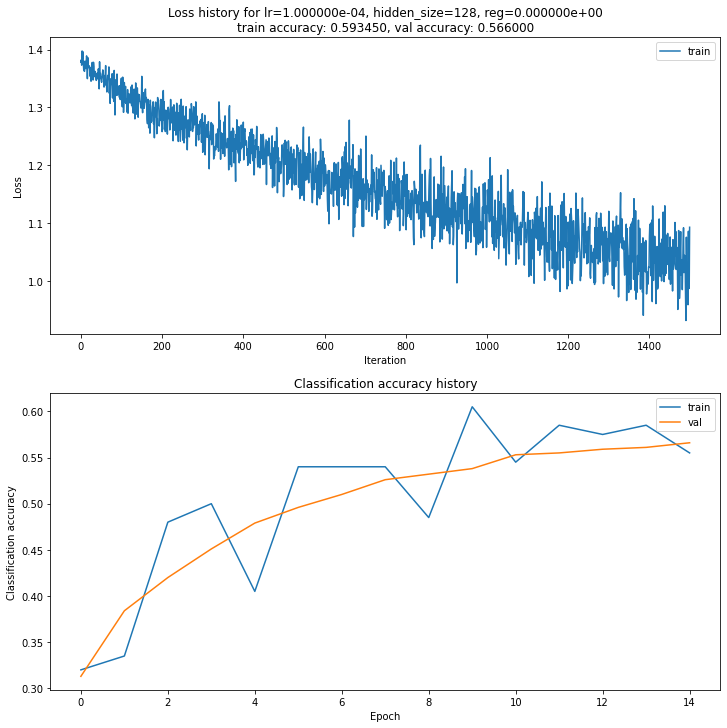

iteration 100 / 1500: loss 1.341491
iteration 200 / 1500: loss 1.297209
iteration 300 / 1500: loss 1.277582
iteration 400 / 1500: loss 1.217437
iteration 500 / 1500: loss 1.240925
iteration 600 / 1500: loss 1.206570
iteration 700 / 1500: loss 1.189356
iteration 800 / 1500: loss 1.172560
iteration 900 / 1500: loss 1.144085
iteration 1000 / 1500: loss 1.144418
iteration 1100 / 1500: loss 1.100847
iteration 1200 / 1500: loss 1.102851
iteration 1300 / 1500: loss 1.016687
iteration 1400 / 1500: loss 1.048110
iteration 1500 / 1500: loss 1.060086
Validation accuracy:  0.586
Training accuracy:  0.5918


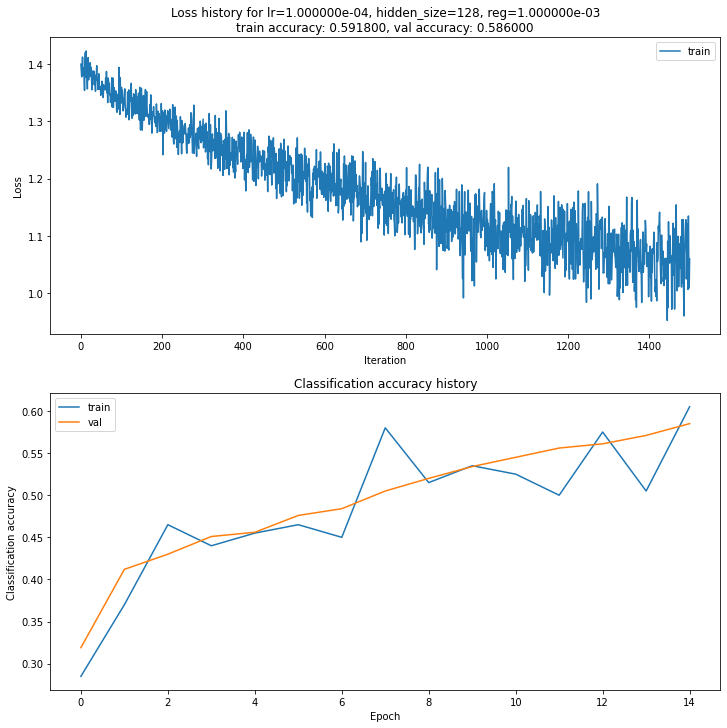

iteration 100 / 1500: loss 3.396352
iteration 200 / 1500: loss 3.369221
iteration 300 / 1500: loss 3.309109
iteration 400 / 1500: loss 3.227977
iteration 500 / 1500: loss 3.230327
iteration 600 / 1500: loss 3.227389
iteration 700 / 1500: loss 3.233777
iteration 800 / 1500: loss 3.164558
iteration 900 / 1500: loss 3.161848
iteration 1000 / 1500: loss 3.115356
iteration 1100 / 1500: loss 3.171721
iteration 1200 / 1500: loss 3.065127
iteration 1300 / 1500: loss 3.058281
iteration 1400 / 1500: loss 3.129689
iteration 1500 / 1500: loss 3.110737
Validation accuracy:  0.571
Training accuracy:  0.59115


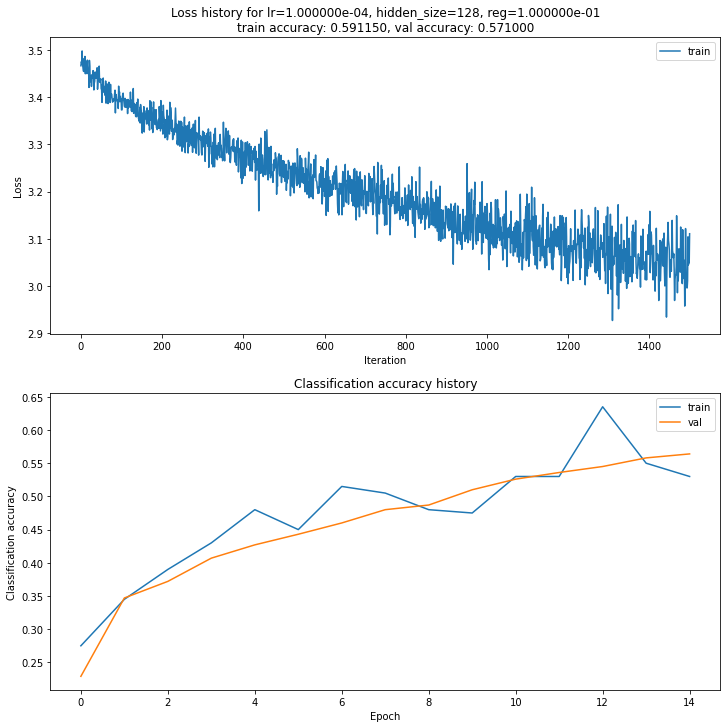

iteration 100 / 1500: loss 6.427202
iteration 200 / 1500: loss 6.381548
iteration 300 / 1500: loss 6.284002
iteration 400 / 1500: loss 6.277796
iteration 500 / 1500: loss 6.235141
iteration 600 / 1500: loss 6.122083
iteration 700 / 1500: loss 6.130816
iteration 800 / 1500: loss 6.087601
iteration 900 / 1500: loss 6.043420
iteration 1000 / 1500: loss 5.958779
iteration 1100 / 1500: loss 6.010867
iteration 1200 / 1500: loss 5.900614
iteration 1300 / 1500: loss 5.886692
iteration 1400 / 1500: loss 5.852281
iteration 1500 / 1500: loss 5.852072
Validation accuracy:  0.581
Training accuracy:  0.58075


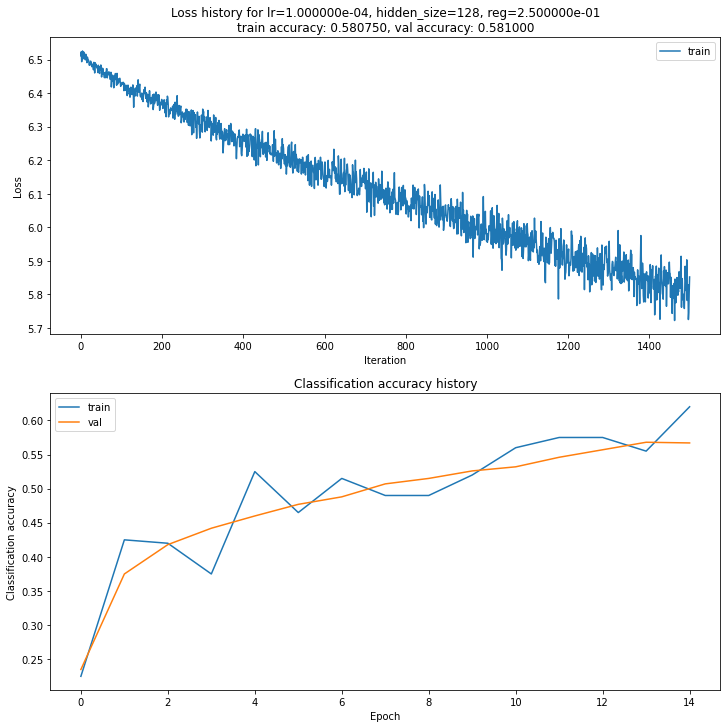

iteration 100 / 1500: loss 1.269713
iteration 200 / 1500: loss 1.252950
iteration 300 / 1500: loss 1.150169
iteration 400 / 1500: loss 1.154076
iteration 500 / 1500: loss 1.077572
iteration 600 / 1500: loss 1.054765
iteration 700 / 1500: loss 1.000135
iteration 800 / 1500: loss 1.078582
iteration 900 / 1500: loss 1.020130
iteration 1000 / 1500: loss 0.989954
iteration 1100 / 1500: loss 0.967979
iteration 1200 / 1500: loss 1.039237
iteration 1300 / 1500: loss 0.918317
iteration 1400 / 1500: loss 0.890411
iteration 1500 / 1500: loss 0.941545
Validation accuracy:  0.623
Training accuracy:  0.6271


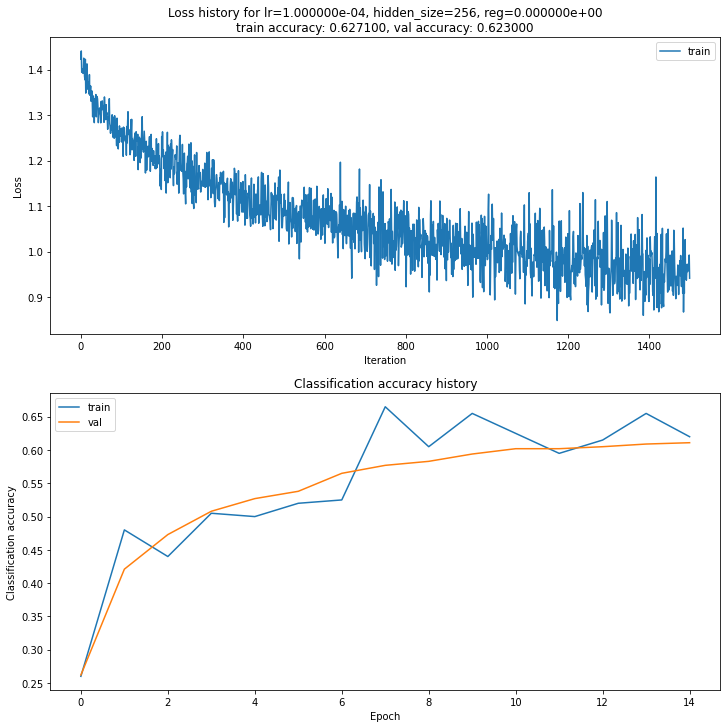

iteration 100 / 1500: loss 1.341439
iteration 200 / 1500: loss 1.291178
iteration 300 / 1500: loss 1.178354
iteration 400 / 1500: loss 1.152560
iteration 500 / 1500: loss 1.153064
iteration 600 / 1500: loss 1.096256
iteration 700 / 1500: loss 1.049760
iteration 800 / 1500: loss 1.116127
iteration 900 / 1500: loss 1.031948
iteration 1000 / 1500: loss 1.084458
iteration 1100 / 1500: loss 1.066807
iteration 1200 / 1500: loss 1.041488
iteration 1300 / 1500: loss 0.977255
iteration 1400 / 1500: loss 0.958795
iteration 1500 / 1500: loss 0.997366
Validation accuracy:  0.626
Training accuracy:  0.632


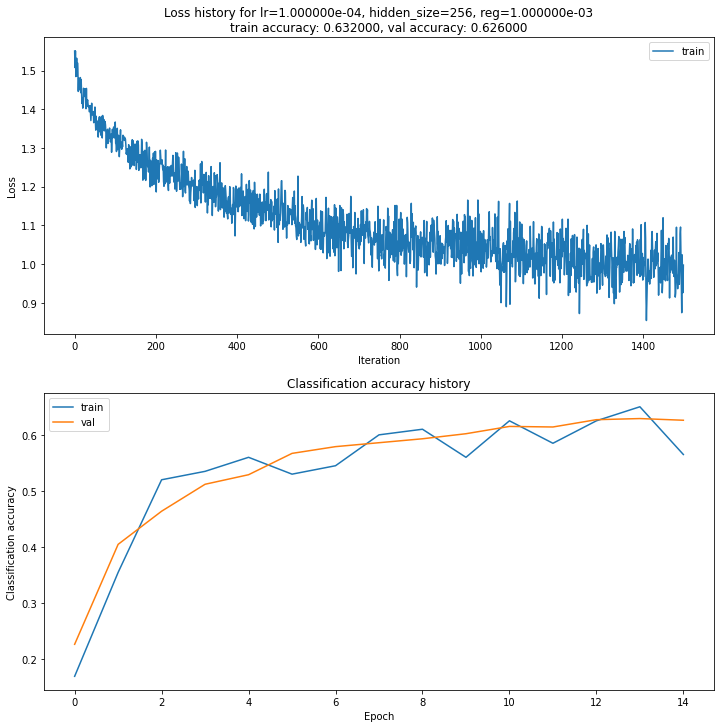

iteration 100 / 1500: loss 5.554900
iteration 200 / 1500: loss 5.429610
iteration 300 / 1500: loss 5.428595
iteration 400 / 1500: loss 5.334466
iteration 500 / 1500: loss 5.285452
iteration 600 / 1500: loss 5.206261
iteration 700 / 1500: loss 5.281975
iteration 800 / 1500: loss 5.174317
iteration 900 / 1500: loss 5.195816
iteration 1000 / 1500: loss 5.136611
iteration 1100 / 1500: loss 5.176365
iteration 1200 / 1500: loss 5.197899
iteration 1300 / 1500: loss 5.062352
iteration 1400 / 1500: loss 5.142181
iteration 1500 / 1500: loss 5.014238
Validation accuracy:  0.632
Training accuracy:  0.63315


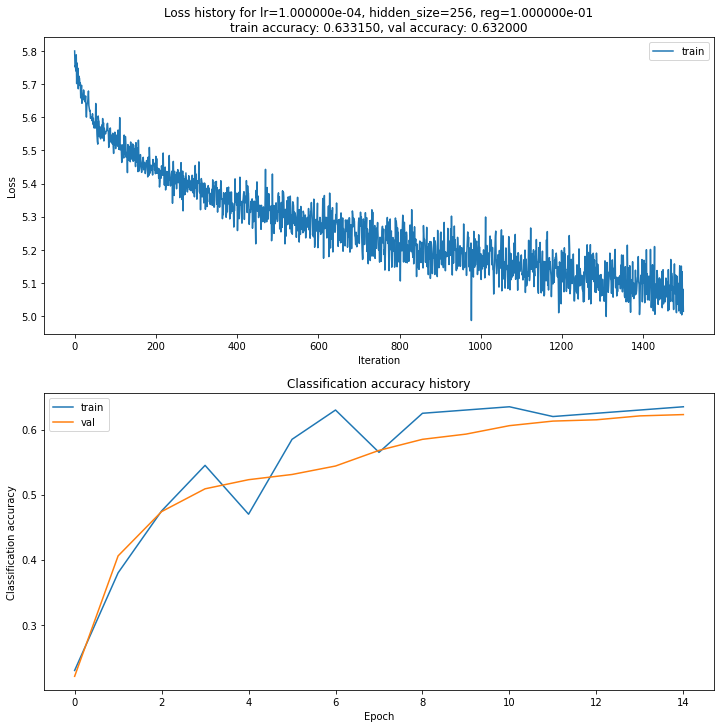

iteration 100 / 1500: loss 11.924058
iteration 200 / 1500: loss 11.813179
iteration 300 / 1500: loss 11.655303
iteration 400 / 1500: loss 11.578994
iteration 500 / 1500: loss 11.567276
iteration 600 / 1500: loss 11.420348
iteration 700 / 1500: loss 11.307921
iteration 800 / 1500: loss 11.328827
iteration 900 / 1500: loss 11.229486
iteration 1000 / 1500: loss 11.181962
iteration 1100 / 1500: loss 11.093408
iteration 1200 / 1500: loss 10.979761
iteration 1300 / 1500: loss 10.922607
iteration 1400 / 1500: loss 10.825963
iteration 1500 / 1500: loss 10.863795
Validation accuracy:  0.6
Training accuracy:  0.62665


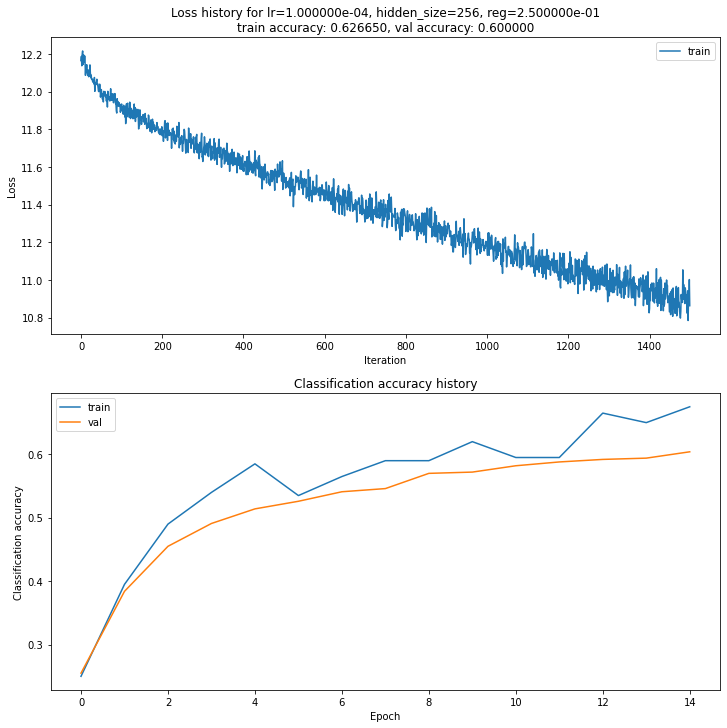

iteration 100 / 1500: loss 1.325927
iteration 200 / 1500: loss 1.230895
iteration 300 / 1500: loss 1.150881
iteration 400 / 1500: loss 1.092113
iteration 500 / 1500: loss 0.970424
iteration 600 / 1500: loss 0.915745
iteration 700 / 1500: loss 0.895929
iteration 800 / 1500: loss 0.825195
iteration 900 / 1500: loss 0.766518
iteration 1000 / 1500: loss 0.738390
iteration 1100 / 1500: loss 0.812761
iteration 1200 / 1500: loss 0.808606
iteration 1300 / 1500: loss 0.747547
iteration 1400 / 1500: loss 0.780748
iteration 1500 / 1500: loss 0.769186
Validation accuracy:  0.68
Training accuracy:  0.703


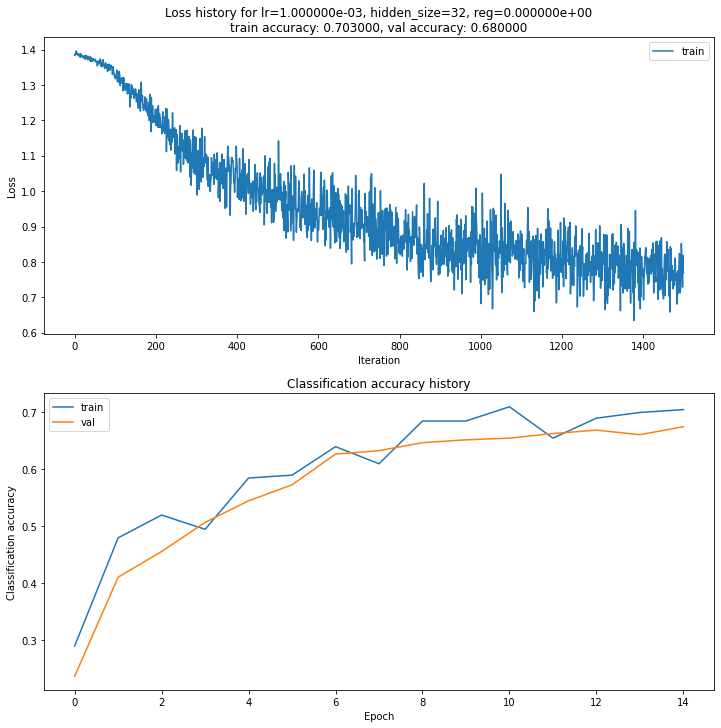

iteration 100 / 1500: loss 1.347365
iteration 200 / 1500: loss 1.278792
iteration 300 / 1500: loss 1.096960
iteration 400 / 1500: loss 1.018424
iteration 500 / 1500: loss 1.052599
iteration 600 / 1500: loss 0.870412
iteration 700 / 1500: loss 0.881626
iteration 800 / 1500: loss 0.980220
iteration 900 / 1500: loss 0.835009
iteration 1000 / 1500: loss 0.835849
iteration 1100 / 1500: loss 0.795565
iteration 1200 / 1500: loss 0.869316
iteration 1300 / 1500: loss 0.856763
iteration 1400 / 1500: loss 0.816196
iteration 1500 / 1500: loss 0.680446
Validation accuracy:  0.685
Training accuracy:  0.7012


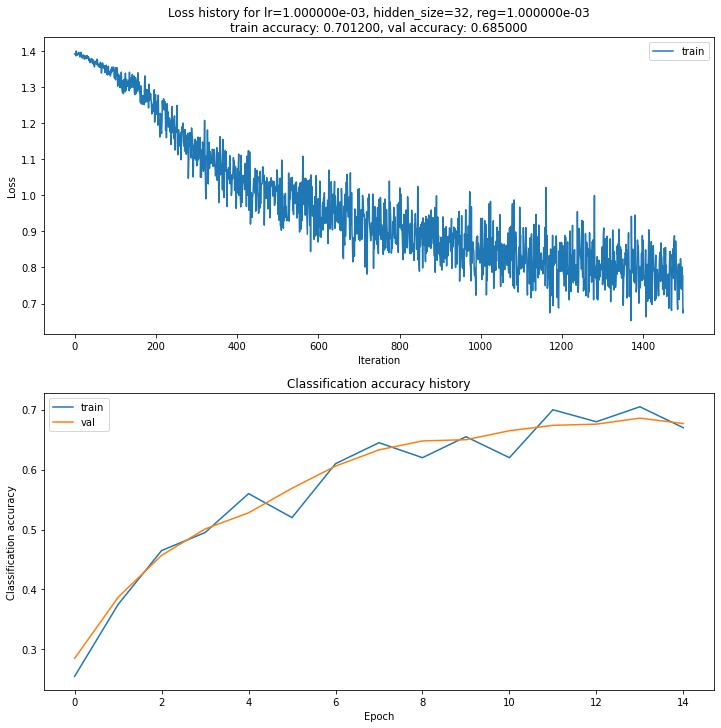

iteration 100 / 1500: loss 1.808572
iteration 200 / 1500: loss 1.726551
iteration 300 / 1500: loss 1.529810
iteration 400 / 1500: loss 1.443590
iteration 500 / 1500: loss 1.465169
iteration 600 / 1500: loss 1.441374
iteration 700 / 1500: loss 1.364428
iteration 800 / 1500: loss 1.360549
iteration 900 / 1500: loss 1.293289
iteration 1000 / 1500: loss 1.254650
iteration 1100 / 1500: loss 1.299346
iteration 1200 / 1500: loss 1.289835
iteration 1300 / 1500: loss 1.235448
iteration 1400 / 1500: loss 1.193010
iteration 1500 / 1500: loss 1.180883
Validation accuracy:  0.691
Training accuracy:  0.70415


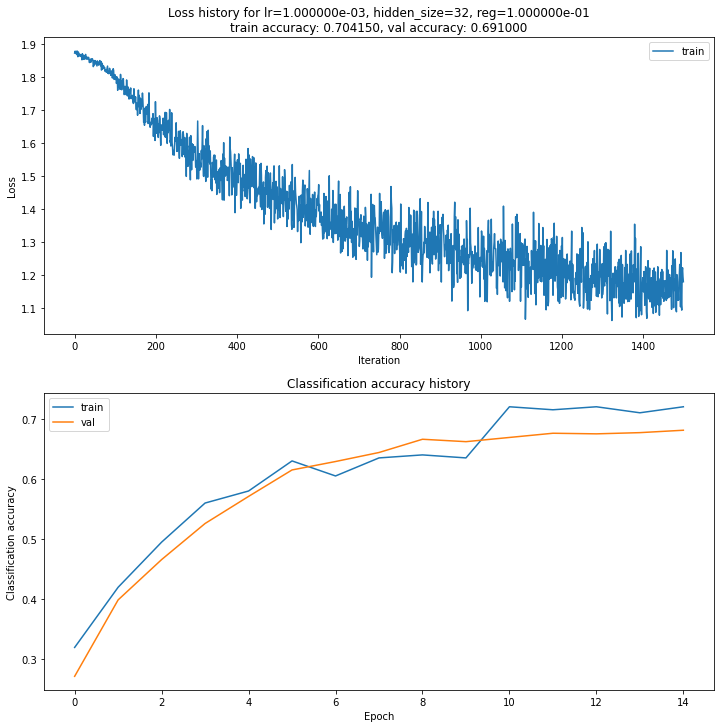

iteration 100 / 1500: loss 2.490111
iteration 200 / 1500: loss 2.274397
iteration 300 / 1500: loss 2.159300
iteration 400 / 1500: loss 2.143118
iteration 500 / 1500: loss 1.917951
iteration 600 / 1500: loss 1.959081
iteration 700 / 1500: loss 1.769445
iteration 800 / 1500: loss 1.744333
iteration 900 / 1500: loss 1.653879
iteration 1000 / 1500: loss 1.578474
iteration 1100 / 1500: loss 1.567499
iteration 1200 / 1500: loss 1.559437
iteration 1300 / 1500: loss 1.499744
iteration 1400 / 1500: loss 1.495675
iteration 1500 / 1500: loss 1.411604
Validation accuracy:  0.673
Training accuracy:  0.6961


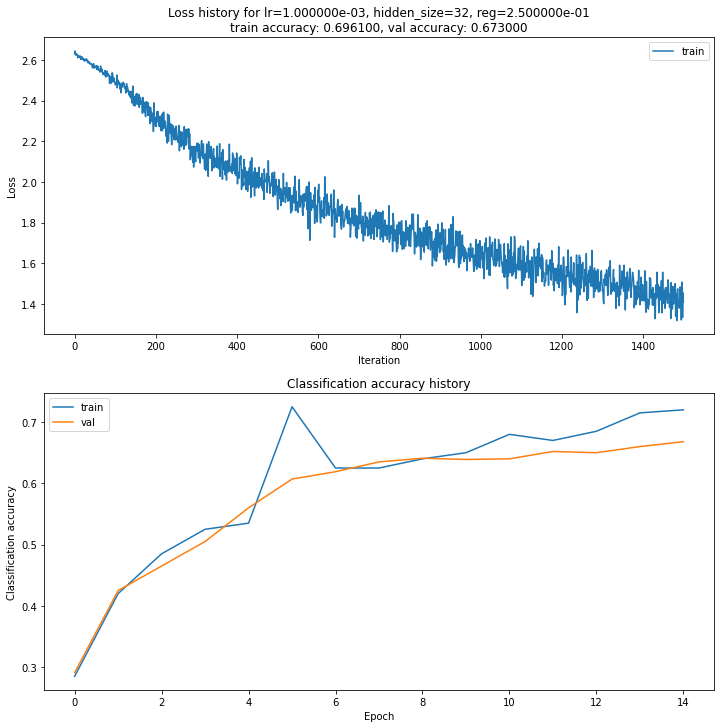

iteration 100 / 1500: loss 1.252160
iteration 200 / 1500: loss 1.119552
iteration 300 / 1500: loss 0.957003
iteration 400 / 1500: loss 0.941817
iteration 500 / 1500: loss 0.863439
iteration 600 / 1500: loss 0.829462
iteration 700 / 1500: loss 0.786916
iteration 800 / 1500: loss 0.901176
iteration 900 / 1500: loss 0.738837
iteration 1000 / 1500: loss 0.825851
iteration 1100 / 1500: loss 0.742950
iteration 1200 / 1500: loss 0.690553
iteration 1300 / 1500: loss 0.793091
iteration 1400 / 1500: loss 0.649507
iteration 1500 / 1500: loss 0.755551
Validation accuracy:  0.678
Training accuracy:  0.7164


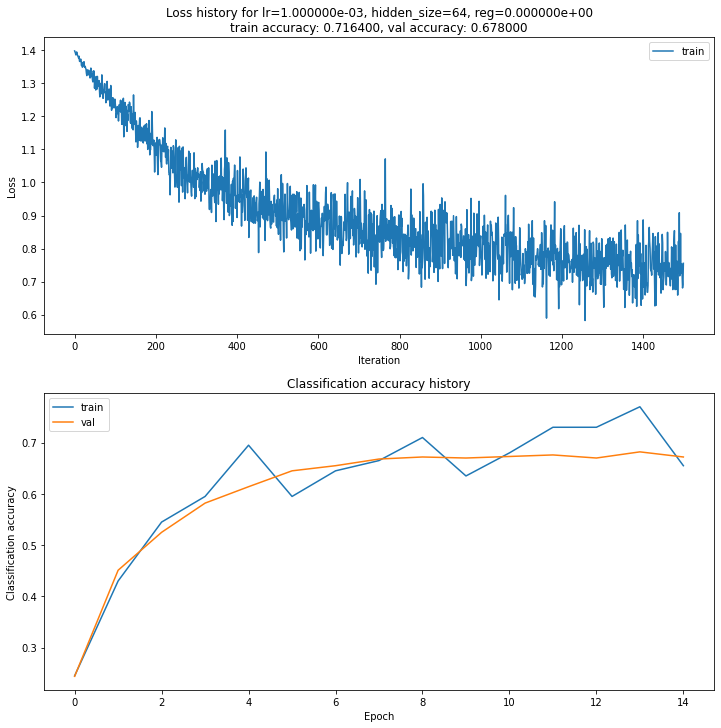

iteration 100 / 1500: loss 1.193126
iteration 200 / 1500: loss 1.138235
iteration 300 / 1500: loss 1.053244
iteration 400 / 1500: loss 0.871866
iteration 500 / 1500: loss 0.824494
iteration 600 / 1500: loss 0.802118
iteration 700 / 1500: loss 0.857847
iteration 800 / 1500: loss 0.818799
iteration 900 / 1500: loss 0.716105
iteration 1000 / 1500: loss 0.707272
iteration 1100 / 1500: loss 0.864530
iteration 1200 / 1500: loss 0.664559
iteration 1300 / 1500: loss 0.803049
iteration 1400 / 1500: loss 0.816486
iteration 1500 / 1500: loss 0.752642
Validation accuracy:  0.695
Training accuracy:  0.7176


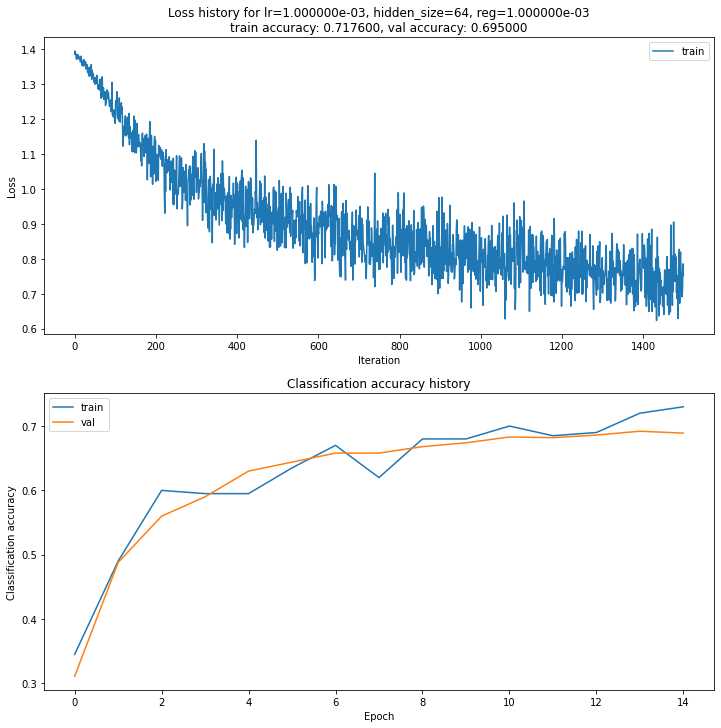

iteration 100 / 1500: loss 2.190089
iteration 200 / 1500: loss 2.129456
iteration 300 / 1500: loss 1.932894
iteration 400 / 1500: loss 1.763069
iteration 500 / 1500: loss 1.890201
iteration 600 / 1500: loss 1.777775
iteration 700 / 1500: loss 1.741980
iteration 800 / 1500: loss 1.736125
iteration 900 / 1500: loss 1.631569
iteration 1000 / 1500: loss 1.584744
iteration 1100 / 1500: loss 1.590962
iteration 1200 / 1500: loss 1.519629
iteration 1300 / 1500: loss 1.527499
iteration 1400 / 1500: loss 1.494112
iteration 1500 / 1500: loss 1.545042
Validation accuracy:  0.678
Training accuracy:  0.71825


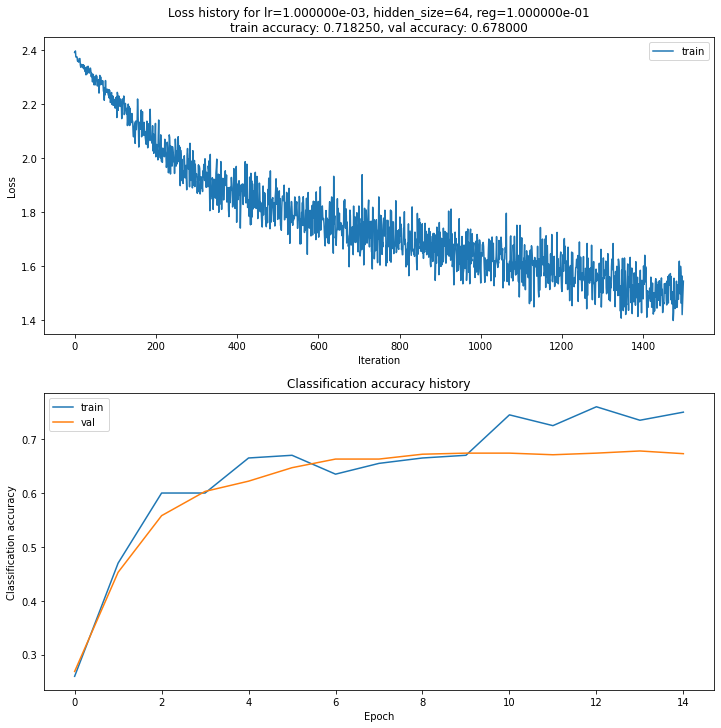

iteration 100 / 1500: loss 3.613087
iteration 200 / 1500: loss 3.405027
iteration 300 / 1500: loss 3.227532
iteration 400 / 1500: loss 3.101931
iteration 500 / 1500: loss 2.955061
iteration 600 / 1500: loss 2.742639
iteration 700 / 1500: loss 2.667645
iteration 800 / 1500: loss 2.605209
iteration 900 / 1500: loss 2.412733
iteration 1000 / 1500: loss 2.342415
iteration 1100 / 1500: loss 2.269865
iteration 1200 / 1500: loss 2.230745
iteration 1300 / 1500: loss 2.038561
iteration 1400 / 1500: loss 2.050690
iteration 1500 / 1500: loss 2.045784
Validation accuracy:  0.686
Training accuracy:  0.71905


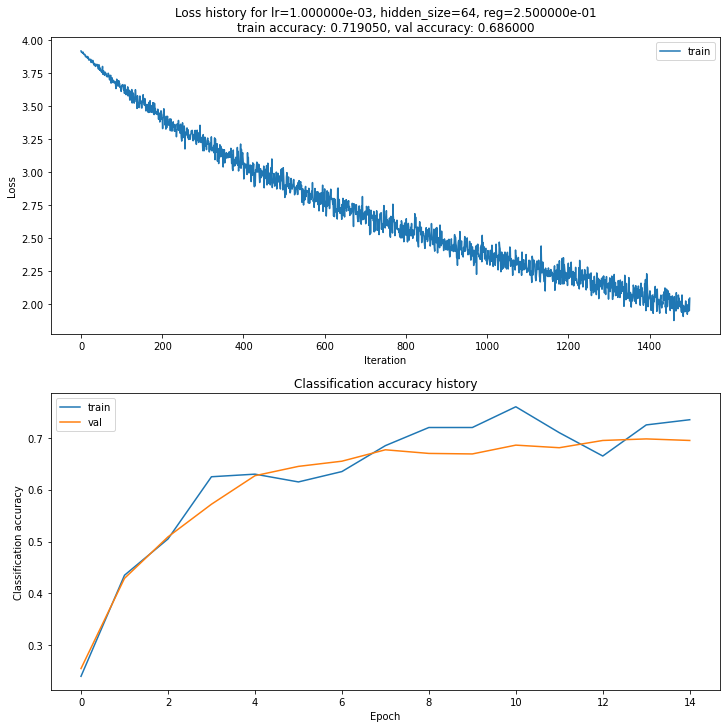

iteration 100 / 1500: loss 1.073080
iteration 200 / 1500: loss 1.072364
iteration 300 / 1500: loss 0.952623
iteration 400 / 1500: loss 0.829898
iteration 500 / 1500: loss 0.799670
iteration 600 / 1500: loss 0.787941
iteration 700 / 1500: loss 0.710752
iteration 800 / 1500: loss 0.731989
iteration 900 / 1500: loss 0.728427
iteration 1000 / 1500: loss 0.799085
iteration 1100 / 1500: loss 0.720346
iteration 1200 / 1500: loss 0.718851
iteration 1300 / 1500: loss 0.703591
iteration 1400 / 1500: loss 0.662492
iteration 1500 / 1500: loss 0.675973
Validation accuracy:  0.695
Training accuracy:  0.7445


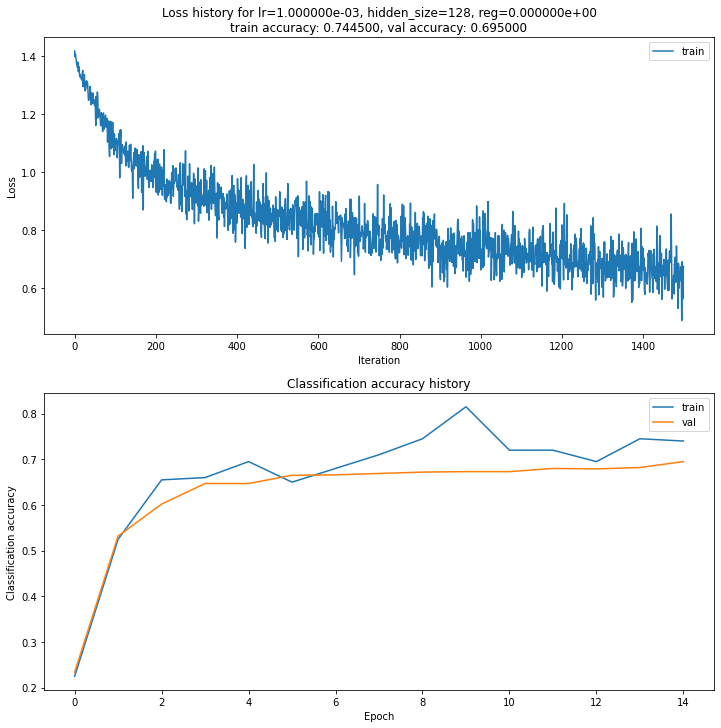

iteration 100 / 1500: loss 1.093479
iteration 200 / 1500: loss 1.032819
iteration 300 / 1500: loss 0.897151
iteration 400 / 1500: loss 0.984163
iteration 500 / 1500: loss 0.966352
iteration 600 / 1500: loss 0.756231
iteration 700 / 1500: loss 0.843636
iteration 800 / 1500: loss 0.771078
iteration 900 / 1500: loss 0.783831
iteration 1000 / 1500: loss 0.778899
iteration 1100 / 1500: loss 0.744228
iteration 1200 / 1500: loss 0.723398
iteration 1300 / 1500: loss 0.595835
iteration 1400 / 1500: loss 0.803108
iteration 1500 / 1500: loss 0.681229
Validation accuracy:  0.701
Training accuracy:  0.7417


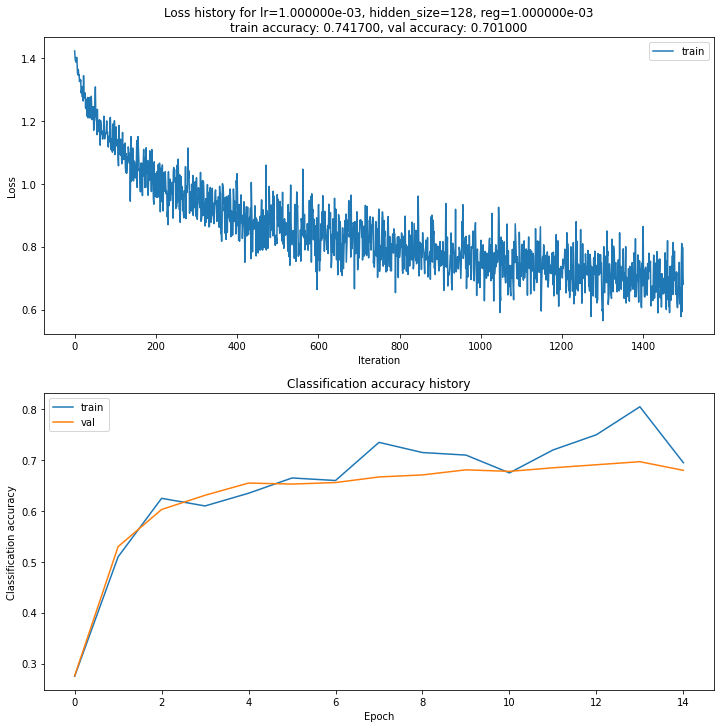

iteration 100 / 1500: loss 3.138721
iteration 200 / 1500: loss 2.963997
iteration 300 / 1500: loss 2.848088
iteration 400 / 1500: loss 2.860654
iteration 500 / 1500: loss 2.698688
iteration 600 / 1500: loss 2.727038
iteration 700 / 1500: loss 2.652930
iteration 800 / 1500: loss 2.572916
iteration 900 / 1500: loss 2.469880
iteration 1000 / 1500: loss 2.472788
iteration 1100 / 1500: loss 2.426606
iteration 1200 / 1500: loss 2.361572
iteration 1300 / 1500: loss 2.368373
iteration 1400 / 1500: loss 2.163694
iteration 1500 / 1500: loss 2.203429
Validation accuracy:  0.7
Training accuracy:  0.73545


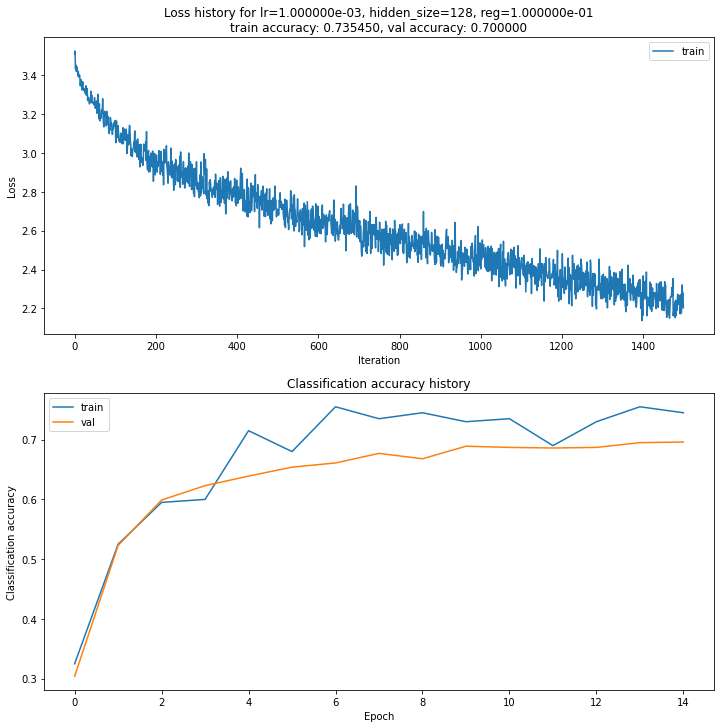

iteration 100 / 1500: loss 6.001325
iteration 200 / 1500: loss 5.611371
iteration 300 / 1500: loss 5.379569
iteration 400 / 1500: loss 5.100231
iteration 500 / 1500: loss 4.811203
iteration 600 / 1500: loss 4.669541
iteration 700 / 1500: loss 4.512265
iteration 800 / 1500: loss 4.274461
iteration 900 / 1500: loss 4.074706
iteration 1000 / 1500: loss 3.914801
iteration 1100 / 1500: loss 3.805451
iteration 1200 / 1500: loss 3.588719
iteration 1300 / 1500: loss 3.509187
iteration 1400 / 1500: loss 3.254777
iteration 1500 / 1500: loss 3.100377
Validation accuracy:  0.709
Training accuracy:  0.73815


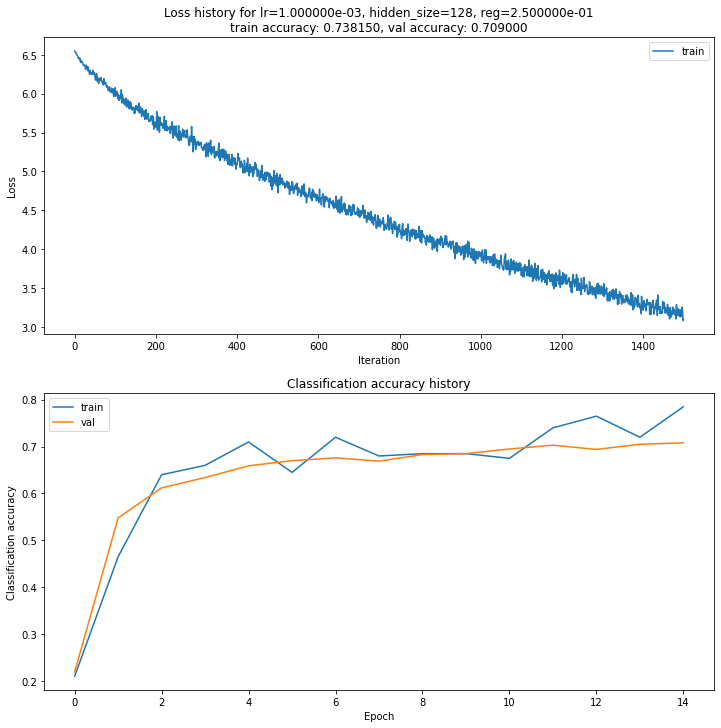

iteration 100 / 1500: loss 1.068804
iteration 200 / 1500: loss 1.018815
iteration 300 / 1500: loss 0.809774
iteration 400 / 1500: loss 0.894112
iteration 500 / 1500: loss 0.779059
iteration 600 / 1500: loss 0.737769
iteration 700 / 1500: loss 0.784133
iteration 800 / 1500: loss 0.698979
iteration 900 / 1500: loss 0.756441
iteration 1000 / 1500: loss 0.594558
iteration 1100 / 1500: loss 0.735506
iteration 1200 / 1500: loss 0.712848
iteration 1300 / 1500: loss 0.612134
iteration 1400 / 1500: loss 0.651813
iteration 1500 / 1500: loss 0.588221
Validation accuracy:  0.703
Training accuracy:  0.77355


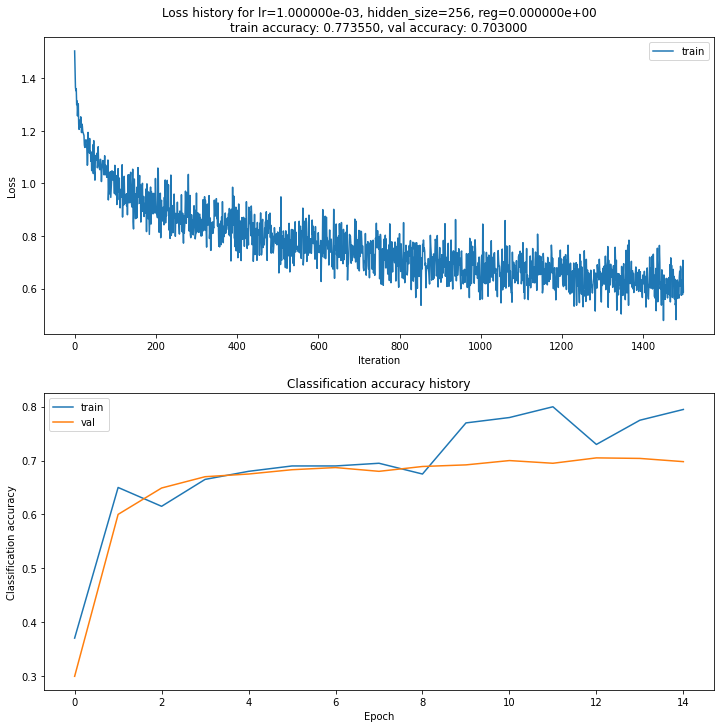

iteration 100 / 1500: loss 0.954675
iteration 200 / 1500: loss 0.891673
iteration 300 / 1500: loss 0.974563
iteration 400 / 1500: loss 0.898234
iteration 500 / 1500: loss 0.899279
iteration 600 / 1500: loss 0.822958
iteration 700 / 1500: loss 0.833856
iteration 800 / 1500: loss 0.835745
iteration 900 / 1500: loss 0.778514
iteration 1000 / 1500: loss 0.715753
iteration 1100 / 1500: loss 0.637900
iteration 1200 / 1500: loss 0.661926
iteration 1300 / 1500: loss 0.733909
iteration 1400 / 1500: loss 0.682050
iteration 1500 / 1500: loss 0.688191
Validation accuracy:  0.697
Training accuracy:  0.7748


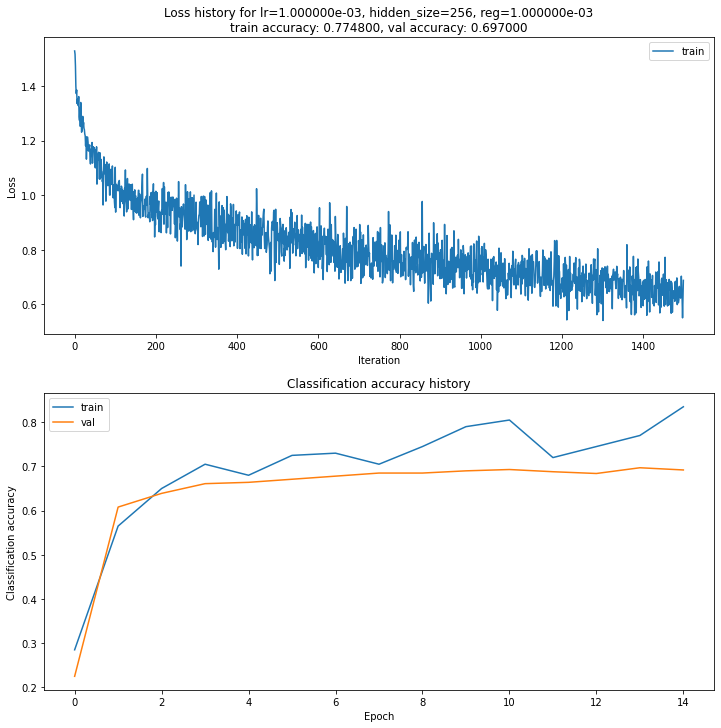

iteration 100 / 1500: loss 5.146438
iteration 200 / 1500: loss 5.037062
iteration 300 / 1500: loss 4.866895
iteration 400 / 1500: loss 4.727403
iteration 500 / 1500: loss 4.665659
iteration 600 / 1500: loss 4.552109
iteration 700 / 1500: loss 4.485466
iteration 800 / 1500: loss 4.390588
iteration 900 / 1500: loss 4.301882
iteration 1000 / 1500: loss 4.240019
iteration 1100 / 1500: loss 4.081104
iteration 1200 / 1500: loss 4.026196
iteration 1300 / 1500: loss 3.884951
iteration 1400 / 1500: loss 3.937607
iteration 1500 / 1500: loss 3.758519
Validation accuracy:  0.701
Training accuracy:  0.76205


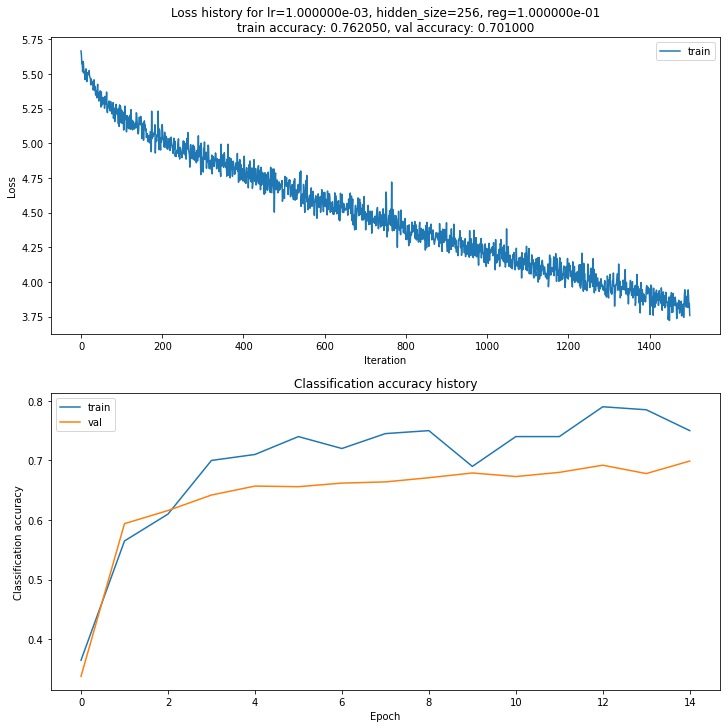

iteration 100 / 1500: loss 11.198553
iteration 200 / 1500: loss 10.572211
iteration 300 / 1500: loss 10.055594
iteration 400 / 1500: loss 9.567698
iteration 500 / 1500: loss 9.156290
iteration 600 / 1500: loss 8.707402
iteration 700 / 1500: loss 8.267700
iteration 800 / 1500: loss 7.870501
iteration 900 / 1500: loss 7.644545
iteration 1000 / 1500: loss 7.223666
iteration 1100 / 1500: loss 6.954809
iteration 1200 / 1500: loss 6.677303
iteration 1300 / 1500: loss 6.241080
iteration 1400 / 1500: loss 6.087587
iteration 1500 / 1500: loss 5.818267
Validation accuracy:  0.706
Training accuracy:  0.7608


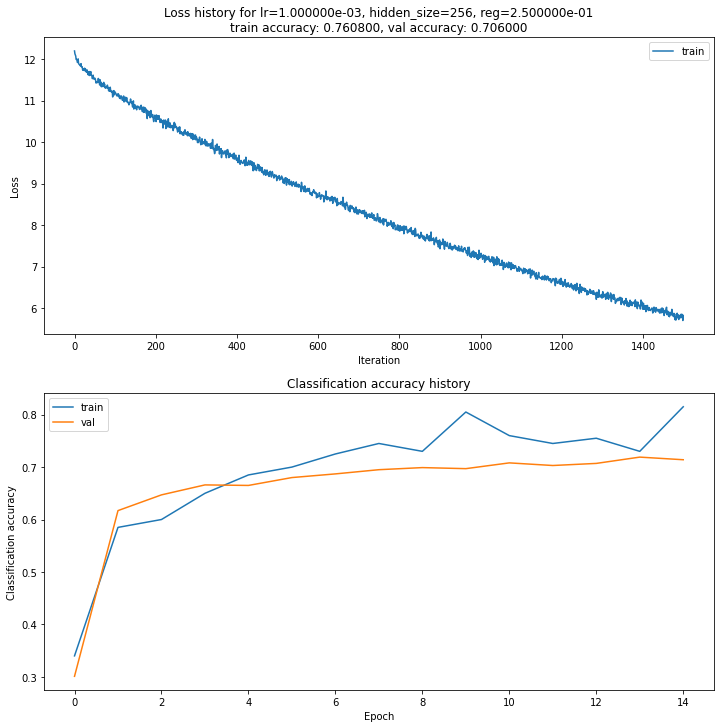

lr 1.000000e-04 hidden_size 32.000000 reg 0.000000 train accuracy: 0.445700 val accuracy: 0.435000
lr 1.000000e-04 hidden_size 32.000000 reg 0.001000 train accuracy: 0.445750 val accuracy: 0.443000
lr 1.000000e-04 hidden_size 32.000000 reg 0.100000 train accuracy: 0.447300 val accuracy: 0.450000
lr 1.000000e-04 hidden_size 32.000000 reg 0.250000 train accuracy: 0.441800 val accuracy: 0.427000
lr 1.000000e-04 hidden_size 64.000000 reg 0.000000 train accuracy: 0.521700 val accuracy: 0.520000
lr 1.000000e-04 hidden_size 64.000000 reg 0.001000 train accuracy: 0.491200 val accuracy: 0.487000
lr 1.000000e-04 hidden_size 64.000000 reg 0.100000 train accuracy: 0.521800 val accuracy: 0.497000
lr 1.000000e-04 hidden_size 64.000000 reg 0.250000 train accuracy: 0.511100 val accuracy: 0.517000
lr 1.000000e-04 hidden_size 128.000000 reg 0.000000 train accuracy: 0.593450 val accuracy: 0.566000
lr 1.000000e-04 hidden_size 128.000000 reg 0.001000 train accuracy: 0.591800 val accuracy: 0.586000
lr 1.000

In [26]:
# This might take some time, try to expirement with small number of testing parameters before continuing
# You are encouraged to experiment with additional values
learning_rates = [1e-4, 1e-3]
hidden_sizes = [32, 64, 128, 256]
regularizations = [0, 0.001, 0.1, 0.25]


results = {}
best_val = -1   
best_net = None 
################################################################################
#                            START OF YOUR CODE                                #
################################################################################

for lr, hidden_size, regularization in itertools.product(learning_rates, hidden_sizes, regularizations):

    # Create a new instance of the ThreeLayerNet class
    model = ThreeLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = model.train(X_train, y_train, X_val, y_val,
                num_iters=1500, batch_size=200,
                learning_rate=lr, reg=regularization, verbose=True)

    # Predict on the validation set
    val_acc = (model.predict(X_val) == y_val).mean()
    print ('Validation accuracy: ', val_acc)

    # Predict on the training set
    train_acc = (model.predict(X_train) == y_train).mean()
    print ('Training accuracy: ', train_acc)

    # Store results
    results[(lr, hidden_size, regularization)] = (train_acc, val_acc)

    # Plot loss history and train / validation accuracies
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'], label='train')
    plt.title('Loss history for lr=%e, hidden_size=%d, reg=%e' % (lr, hidden_size, regularization) + '\n' + 'train accuracy: %f, val accuracy: %f' % (train_acc, val_acc) )
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')

    plt.legend()

    plt.show()

    # Save best model
    if val_acc > best_val:
        best_val = val_acc
        best_net = model


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, hidden_size, reg  in sorted(results):
    train_accuracy, val_accuracy = results[(lr, hidden_size, reg)]
    print ('lr %e hidden_size %f reg %f train accuracy: %f val accuracy: %f' % (
                lr, hidden_size, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = (best_net.predict(X_test) == y_test).mean()
print ('Neural Network on raw pixels final test set accuracy: %f' % test_accuracy)

# Question

##**Question:** 
What can you say about the training? Why does it take much longer to train (compare to hw1)? **(5 Points)**

**Your answer:** In hw1 we used logistic regression and binary cross entropy, which involve fewer parameters and less complex calculations that result in faster learning time. For neural networks, the complexity increases since the model needs to learn a bigger number of parameters. Through each layer matrix multiplications, activation functions and regularization operations are performed. Hence, as the number of layers increases, the gradient calculations become more complex. The gradient calculated through each layer can become very small as the number of layers increases, which makes it difficult for the model to learn. Also, deep networks with multiple hidden layers can have a more complex decision boundary that will make it harder for the network to find the optimal solution in terms of the set of parameters.

##**Question:** 

What can you say about the diffrence (or lack of thereof) between the validation and training accuracy? What can you say about the connection between the loss and the accuracy? **(5 Points)**

**Your answer:** Indeed, there was little to no difference between the validation and training accuracy when running the model. This indicates that the model generalizes well to unseen data, or in other words, is not overfitting. Also, this can mean that the model complexity is well-suited for the problem at hand. Finally, it also suggests that the validation set is a good representation of the training data. We can therefore conclude that the model is effective and generalizes well to new data.    
Both accuracy and loss refer to a model's performance, however they refer to different things. On one hand, the loss shows the difference between the predicted values and the actual values. On the other hand, accuracy measures how many predictions made by the model are correct. A model with low loss and low accuracy will consistently make small mistakes (low loss) that will be significant enough to lead to incorrect classification (low accuracy). Similarly, a model can make good classifications (high accuracy) with a few but very large errors (high loss). It is important to note that not always a decrease in loss will imply an increase in accuracy, as is the case for imbalanced datasets.

# The End